In [1]:
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt

from src.data_utils import train_val_test_split

In [3]:
VARIABLE = 'N.Percent'
CENTRAL_WAVELENTGHS = {
    'B2_real': 490,
    'B3_real': 560,
    'B4_real': 665,
    'B5_real': 705,
    'B6_real': 740,
    'B7_real': 783,
    'B8_real': 842,
    'B11_real': 1610,
    'B12_real': 2190
}

In [4]:
def calc_vif(X: pd.DataFrame):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

def get_sorted_feature_importances(model, ordered_cols) -> pd.DataFrame:
    """Return sorted features importances as a DataFrame."""
    importances = model.feature_importances_
    feature_importances = pd.DataFrame(importances, index=ordered_cols, columns=["Importance"])
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
    return feature_importances

In [6]:
def plot_residuals(y_test: pd.DataFrame, predictions: pd.DataFrame):
    """Plot residuals."""
    residuals = y_test.astype(np.float32) - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs True Values")
    plt.show()

In [7]:
def fit_predict_rf(X, y, verbose=True):
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor model.
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    # estimator = PLSRegression(n_components=9, scale=True)
    rf = Pipeline([
        ("estimator", estimator)
    ])

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict the trait values
    predictions = rf.predict(X_test)

    # Calculate metrics.
    r_squared = rf.score(X_test, y_test)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    if verbose:
        print(f"R-squared: {r_squared:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Mean Absolute Percentage Error: {mape:.1f}%")

        plot_residuals(y_test, predictions)

    return rf, [r_squared, rmse, mae, mape]

In [4]:
dpath = Path('/Users/campbelli/Documents/mini-project/data')
df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')
# Select only the pixels with 70% of the basal area covered and only community-weighted means.
cwms = df[(df['PercentCovered'] == '70') & (df['Type'] == 'CWMean')]
cwms.loc[:, 'TraitValue'] = pd.to_numeric(cwms['TraitValue'], errors='raise')
var_cwm = cwms[cwms['variable'] == VARIABLE]

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_6558/3735458380.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')


In [5]:
# All commented variables don't seem to be included in the paper.
# ** indicates same value for all pixels in a plot.
bands = [
    'B2_real', # Blue band, 490 nm
    'B3_real', # Green band, 560 nm
    'B4_real', # Red band, 665 nm
    'B5_real', # Red edge band, 705 nm
    'B6_real', # Red edge band, 740 nm
    'B7_real', # Red edge band, 783 nm
    'B8_real', # NIR band, 842 nm
    'B11_real', # SWIR band, 1610 nm
    'B12_real' # SWIR band, 2190 nm
    # 'B8a_real' # NIR band, 865 nm
]
spectral_indices = [
    # 'BNDVI',
    # 'BNDVI_Corr',
    # 'BNDVI_Entropy',
    # 'EVI2', # 2.5 × (NIR - Red) / (NIR + 2.4 × Red + 1)
    # 'EVI2_Corr',
    # 'EVI2_Entropy',
    'MCARI',
    'MCARI_Corr',
    'MCARI_Entropy',
    'MSAVI2', # (2 × NIR + 1 - √((2 × NIR + 1)² - 8 × (NIR - Red))) / 2
    'MSAVI2_Corr',
    'MSAVI2_Entropy',
    'NDRE', #  (NIR - RedEdge)/(NIR + RedEdge)
    'NDRE_Corr',
    'NDRE_Entropy',
    # 'TCARI',
    # 'TCARI_Corr',
    # 'TCARI_Entropy'
]
climate_vars = [
    'CWD', # Climate Water Deficit
    # 'PRE',
    'SoilMoist', # Soil Moisture
    'SRAD', # Solar irradiance
    'Tmax', # Mean annual maximum temperature
    # 'vpd'
]
soil_vars = [
    'Slope', # Terrain slope
    # 'sand', # Sand content
    'sand_perc_plot', # Sand content percentage
    # 'ph', # Soil pH
    'ph_h20_plot', # Soil pH in water 
    # 'clay', # Clay content **
    # 'clay_perc_plot', # Clay content percentage **
    # 'cec', # Cation exchange capacity **
    'CEC_mmol_kg_plot', # Cation exchange capacity **
]

cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

In [6]:
# Find plots where there is no Sentinel-2 data.
null_plots = cwms[cwms[bands].isnull().any(axis=1)].groupby('New_Plot')[bands].count()
null_plots.index

Index(['TRU041006', 'TRU041007', 'TRU041008', 'TRU041019', 'TRU041020',
       'TRU041021', 'TRU041022', 'TRU041031', 'TRU041032', 'TRU041033',
       'TRU041034', 'TRU041043', 'TRU041044', 'TRU041053', 'TRU041054',
       'TRU041061', 'TRU04993', 'TRU04994', 'TRU04995', 'TRU04996'],
      dtype='object', name='New_Plot')

In [7]:
# Drop plots without Sentinel-2 data.
cwms = cwms[~cwms['New_Plot'].isin(null_plots.index)]

In [8]:
# Find number of plots with available data by variable.
cwms.groupby('variable').count()['New_Plot'].sort_values(ascending=False)

variable
Ca.Percent      1888
K.Percent       1888
Mg.Percent      1888
P.Percent       1887
Thickness.mm    1885
Area.cm2        1884
N.Percent       1884
SLA.g.m2        1884
WD              1876
Asat            1548
C.Percent       1537
Fresh.mass.g    1270
Dry.mass.g      1269
Amax            1267
Name: New_Plot, dtype: int64

In [111]:
# Find the plots with data for all variables
intersection_plot_ids = set(cwms['New_Plot'])
for variable in cwms['variable'].unique():
    intersection_plot_ids &= set(cwms[cwms['variable'] == variable]['New_Plot'])

len(list(intersection_plot_ids))

912

In [20]:
# Split data into train, test and validation sets per variable (ignore the unequal amount of data).
train_split = 0.7
validation_split = 0.1
test_split = 0.2

for variable in cwms['variable'].unique():
    # Get the pixels for the current variable
    pixels = cwms[cwms['variable'] == variable].set_index('New_Plot')

    train_pixels, val_pixels, test_pixels = train_val_test_split(pixels, train_split, validation_split)

    if test_pixels.isna().any().any():
        print(f"Variable {variable} has missing values.")
        continue

    # Drop columns not included in the analysis and save data.
    opath = Path('.') / 'data'
    train_pixels[cols].to_csv(opath / 'train' / f'{variable}_train_data.csv')
    val_pixels[cols].to_csv(opath / 'validation' / f'{variable}_val_data.csv')
    test_pixels[cols].to_csv(opath / 'test' / f'{variable}_test_data.csv')

    # Save labels.
    train_pixels['TraitValue'].to_csv(opath / 'train' / f'{variable}_train_labels.csv')
    val_pixels['TraitValue'].to_csv(opath / 'validation' / f'{variable}_val_labels.csv')
    test_pixels['TraitValue'].to_csv(opath / 'test' / f'{variable}_test_labels.csv')

## Look at what parts of the spectrum are sampled by the Sentinel-2 bands

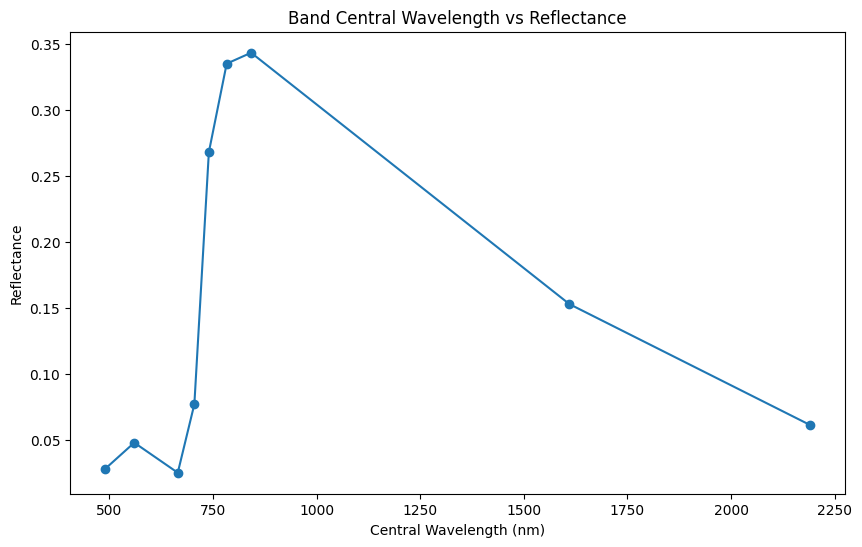

In [379]:
# Plot band central wavelength versus spectral response
plt.figure(figsize=(10, 6))
reflectances = {band: var_cwm[band].iloc[0] for band in CENTRAL_WAVELENTGHS.keys()}
plt.plot(CENTRAL_WAVELENTGHS.values(), reflectances.values(), marker='o')
plt.title("Band Central Wavelength vs Reflectance")
plt.xlabel("Central Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()

## Test multi-collinearity of predictors

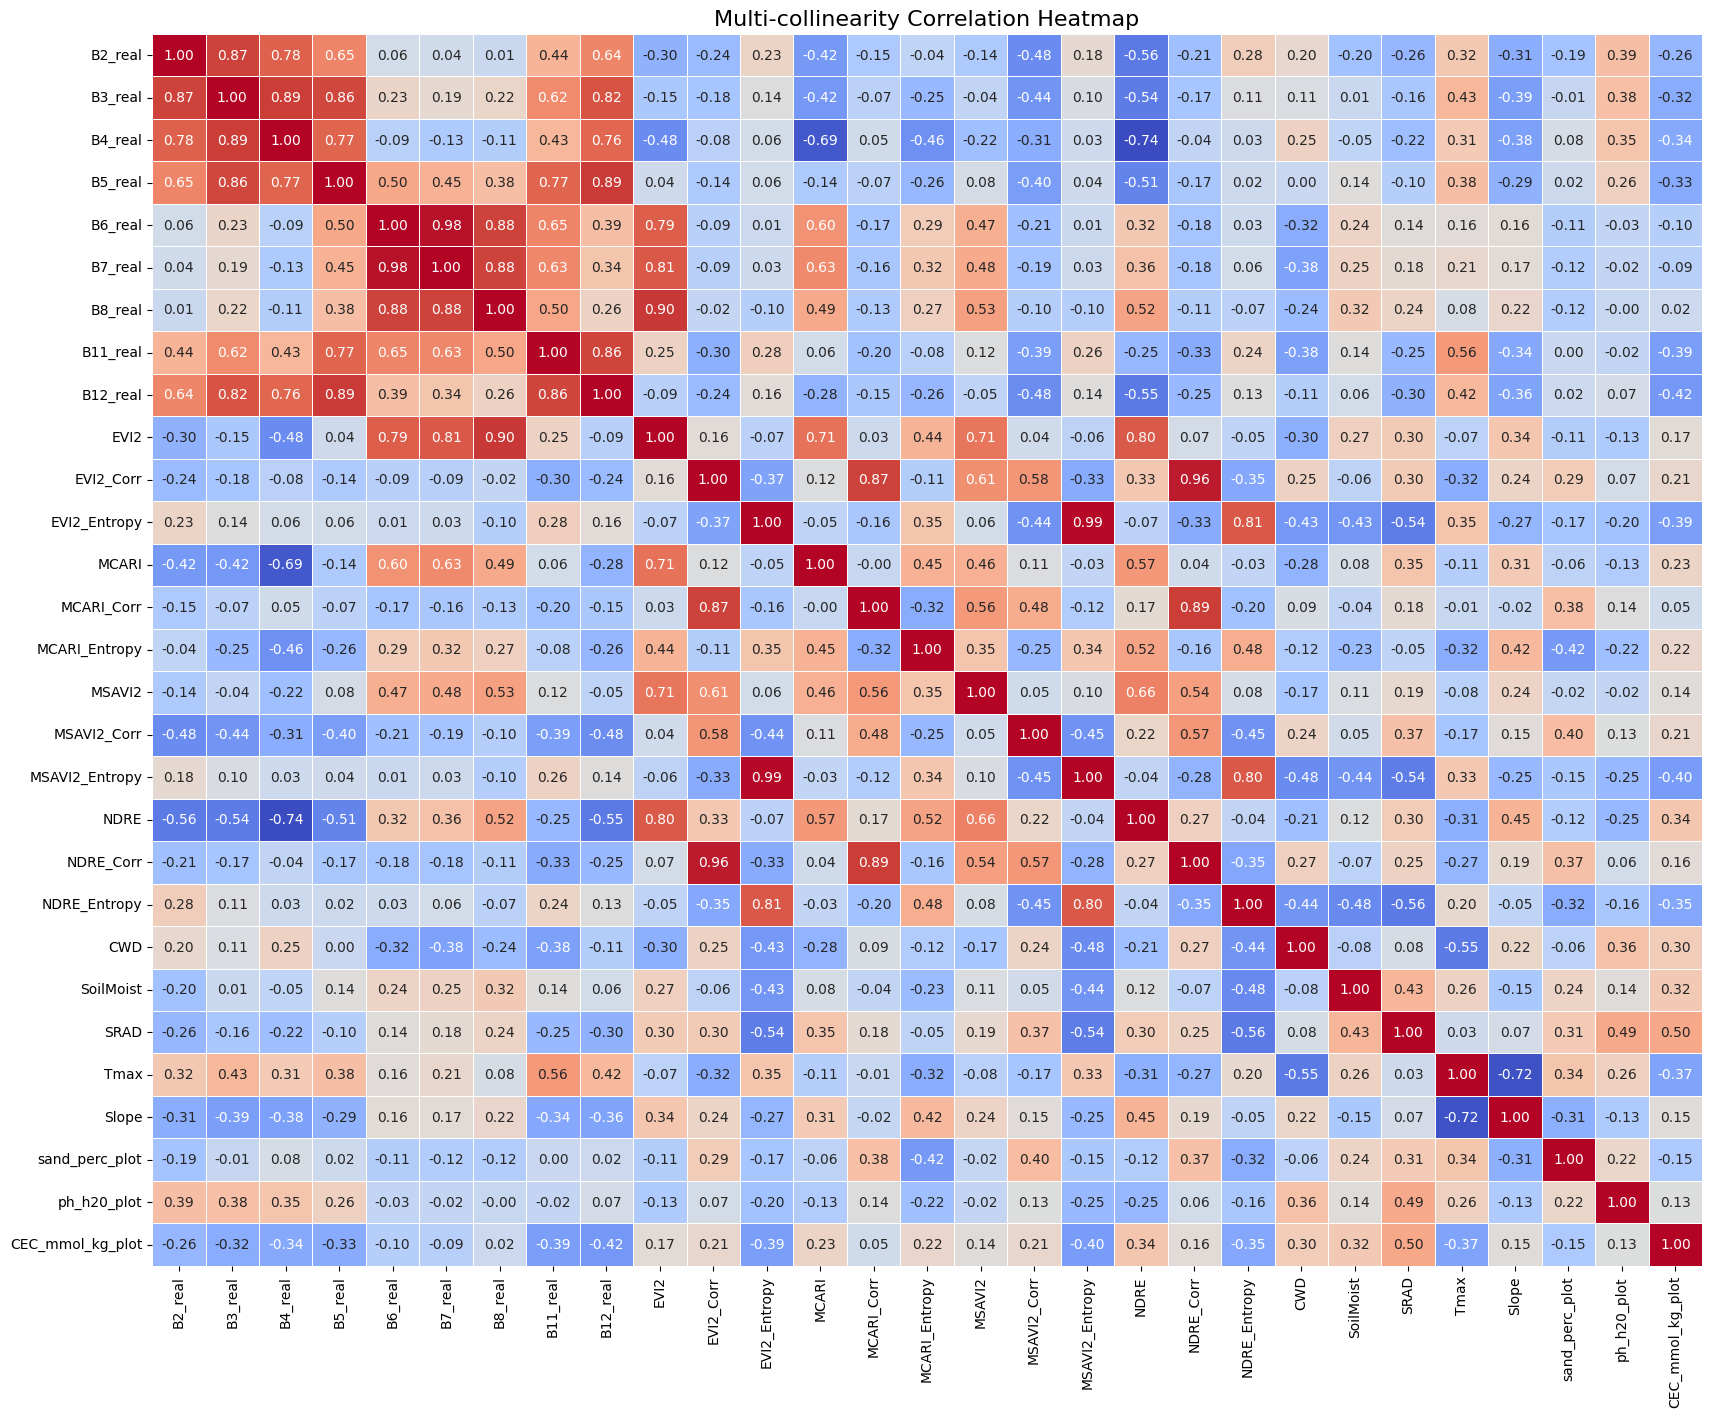

In [140]:
# Correlation matrix
X = var_cwm[cols].dropna(axis=0, how='any')
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False)

# Title for the heatmap
plt.title("Multi-collinearity Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

In [141]:
X = var_cwm[bands].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,B2_real,22.209338
1,B3_real,263.565888
2,B4_real,84.222294
3,B5_real,383.653091
4,B6_real,962.211174
5,B7_real,844.186600
6,B8_real,183.137850
7,B11_real,344.113405
8,B12_real,353.516364


In [13]:
X = var_cwm[spectral_indices].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,MCARI,10.082907
1,MCARI_Corr,2246.069650
2,MCARI_Entropy,81.578511
3,MSAVI2,4.801290
4,MSAVI2_Corr,255.527648
5,MSAVI2_Entropy,65.093804
6,NDRE,157.380338
7,NDRE_Corr,2187.059740
8,NDRE_Entropy,90.448470


In [14]:
var_cwm[spectral_indices].describe()

,MCARI,MCARI_Corr,MCARI_Entropy,MSAVI2,MSAVI2_Corr,MSAVI2_Entropy,NDRE,NDRE_Corr,NDRE_Entropy
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,0.124874,0.957543,7.037658,0.402376,0.957068,6.966717,0.563433,0.964427,6.993977
std,0.057932,0.059018,1.555992,0.424335,0.074114,1.549856,0.095794,0.061996,1.579485
min,0.000000,0.434857,2.772589,-3.276600,0.247215,1.655738,0.000000,0.438572,2.079442
25%,0.075000,0.953697,6.007499,0.373050,0.954739,5.936665,0.524350,0.963710,5.634162
50%,0.129200,0.973482,7.559880,0.458150,0.981147,7.201918,0.581700,0.984307,7.338649
75%,0.161825,0.985412,8.183223,0.527725,0.992058,8.249563,0.625600,0.994268,8.225132
max,0.415800,0.999226,9.427594,0.769100,0.999570,9.368182,0.729800,0.999095,9.358474


In [143]:
X = var_cwm[climate_vars].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,CWD,4.871014
1,SoilMoist,3.450494
2,SRAD,46.591237
3,Tmax,32.748356


In [144]:
X = var_cwm[soil_vars].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,Slope,2.748633
1,sand_perc_plot,5.314712
2,ph_h20_plot,9.570760
3,CEC_mmol_kg_plot,2.337204


In [313]:
X = var_cwm[cols].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,B2_real,48.194835
1,B3_real,358.006000
2,B4_real,795.889996
3,B5_real,1867.203444
4,B6_real,1201.701296
5,B7_real,1210.375527
6,B8_real,11149.588087
7,B11_real,1194.438499
8,B12_real,855.557463
9,EVI2,23841.631689


## Test application of random forest regression model
### Baseline: use a number of randomly selected variables


In [194]:
# Repeat experiment with ranadomly initialized data for mean R^2 score
n_samples = 1000
n_features = len(bands)
n_iterations = 30

y = var_cwm[ 'TraitValue'][:n_samples]

r_squared_scores = []
rmse_scores = []
mape_scores = []

for i in range(n_iterations):
    X = np.random.randn(n_samples, n_features)
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Initialize the RandomForestRegressor model.
    estimator = RandomForestRegressor(n_estimators=100, random_state=i)
    rf = Pipeline(
        [
        ("scaler", StandardScaler()),
        ("estimator", estimator)]
    )

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict the trait values
    predictions = rf.predict(X_test)

    # Calculate metrics.
    r_squared_scores.append(rf.score(X_test, y_test))
    rmse_scores.append(root_mean_squared_error(y_test, predictions))
    mape_scores.append(mean_absolute_percentage_error(y_test, predictions) * 100)

print(f"R-squared: {np.mean(r_squared_scores):.2f}")
print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"MAPE: {np.mean(mape_scores):.1f}%")

R-squared: -0.08
RMSE: 0.69
MAPE: 24.7%


### Use raw bands only

See what information can be extracted from the raw reflectances when treating the bands as independent explainer variables.

R-squared: 0.30
Root Mean Squared Error: 0.54
Mean Absolute Error: 0.33
Mean Absolute Percentage Error: 15.7%


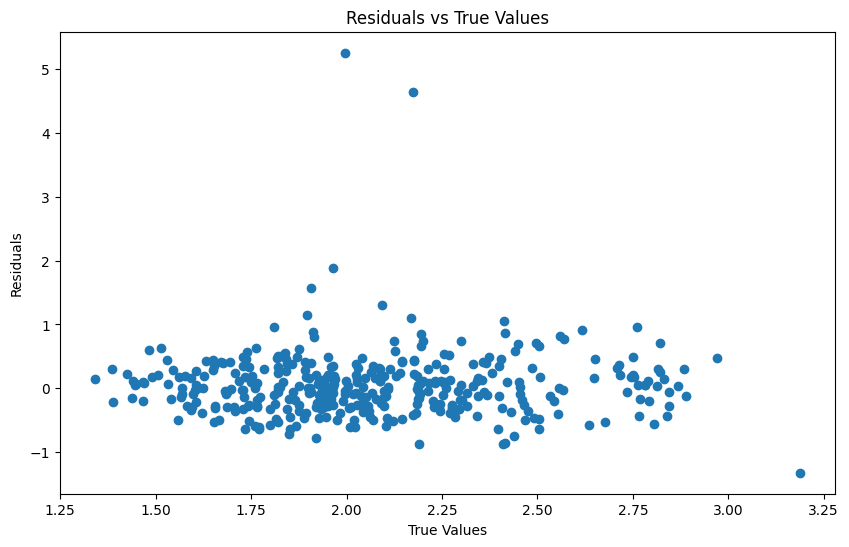

In [27]:
# Remove rows with missing band data.
X = var_cwm[bands].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [401]:
get_sorted_feature_importances(rf.named_steps['estimator'], X.columns).head(10)

,Importance
B12_real,0.289657
B2_real,0.204021
B11_real,0.085077
B5_real,0.083227
B8_real,0.080856
B4_real,0.077130
B7_real,0.061198
B3_real,0.059450
B6_real,0.059383


In [779]:
var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index().drop(columns='level_1', axis=1)

,Location,TraitValue
0,Australia,2.79
1,Ghana,6.821242
2,Ghana,6.767072
3,Ghana,7.331787
4,Ghana,7.255256
5,Malaysia,3.474985
6,Malaysia,3.499841


In [ ]:
var_cwm.drop(var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_zscore).reset_index()['level_1'])

,New_Plot,Country,Location,variable,TraitValue,Type,PercentCovered,X,Y,B11_real,...,Slope,cec,sand,ph,clay,sand_perc_plot,clay_perc_plot,ph_h20_plot,CEC_mmol_kg_plot,B8a_real
393,261_1025,Brazil,Santarem,N.Percent,3.315076,CWMean,70,721755,9666145,0.1527,...,5.01198,6.0,40.0,45.0,47.0,3.6035,74.9125,3.745,18.236201,0.3626
1178,261_1041,Brazil,Santarem,N.Percent,3.181865,CWMean,70,721695,9666135,0.1416,...,5.01198,6.0,40.0,45.0,47.0,3.6035,74.9125,3.745,18.236201,0.2961
1288,261_1042,Brazil,Santarem,N.Percent,2.747279,CWMean,70,721705,9666135,0.1241,...,5.01198,6.0,40.0,45.0,47.0,3.6035,74.9125,3.745,18.236201,0.2791
2130,261_1061,Brazil,Santarem,N.Percent,2.134077,CWMean,70,721645,9666125,0.1484,...,5.01198,6.0,40.0,45.0,47.0,3.6035,74.9125,3.745,18.236201,0.3228
2318,261_1063,Brazil,Santarem,N.Percent,2.052304,CWMean,70,721665,9666125,0.1425,...,5.01198,6.0,40.0,45.0,47.0,3.6035,74.9125,3.745,18.236201,0.2889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430667,WAY011485,Peru,Peru,N.Percent,1.656771,CWMean,70,219525,8540285,0.1257,...,31.89038,19.0,42.0,54.0,24.0,43.6500,16.5000,4.000,42.540000,0.3253
430952,WAY011487,Peru,Peru,N.Percent,1.932057,CWMean,70,219545,8540285,0.1177,...,31.89038,18.0,41.0,55.0,24.0,43.6500,16.5000,4.000,42.540000,0.3040
431007,WAY011488,Peru,Peru,N.Percent,1.734014,CWMean,70,219555,8540285,0.1177,...,31.89038,18.0,41.0,55.0,24.0,43.6500,16.5000,4.000,42.540000,0.3040
431217,WAY011489,Peru,Peru,N.Percent,1.612925,CWMean,70,219565,8540285,0.1096,...,31.89038,18.0,41.0,55.0,24.0,43.6500,16.5000,4.000,42.540000,0.3516


In [239]:
var_cwm.groupby('Location')['TraitValue'].std().sort_values(ascending=False)

Location
Ghana            0.728894
Santarem         0.593672
Gabon            0.481780
Peru             0.416797
Malaysia         0.272976
NovaXavantina    0.194561
Australia        0.188423
Name: TraitValue, dtype: float64

In [248]:
var_cwm.groupby('Location')['TraitValue'].max().sort_values(ascending=False)

Location
Ghana            7.331787
Santarem         3.846812
Gabon            3.640000
Peru             3.534294
Malaysia         3.499841
NovaXavantina    2.880820
Australia        2.790000
Name: TraitValue, dtype: float32

R-squared: 0.45
Root Mean Squared Error: 0.39
Mean Absolute Error: 0.30
Mean Absolute Percentage Error: 15.9%


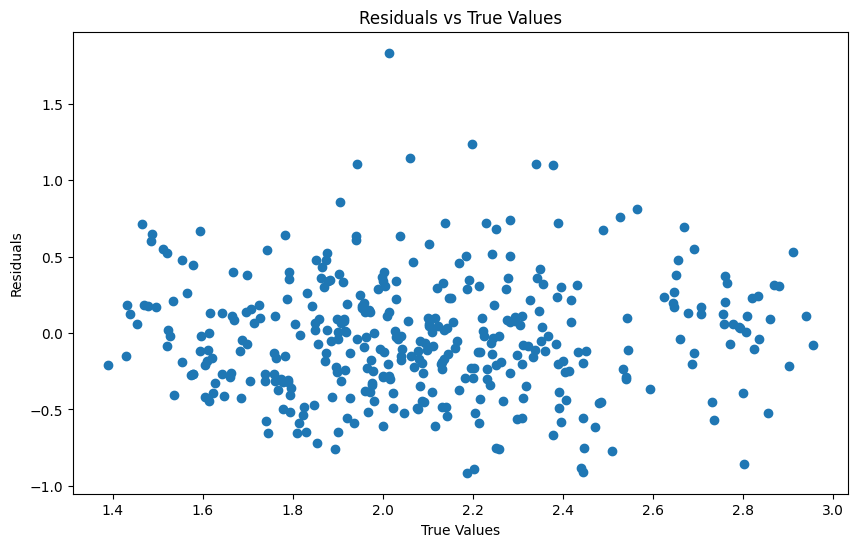

In [28]:
# Remove outliers from the dataset.
outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1']
X = var_cwm.drop(outlier_indices)

# Remove rows with missing band data.
X = X[bands].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf, _ = fit_predict_rf(X, y)

In [404]:
get_sorted_feature_importances(rf.named_steps['estimator'], X.columns).head(10)

,Importance
B12_real,0.270847
B2_real,0.218769
B11_real,0.104995
B5_real,0.083066
B8_real,0.076066
B4_real,0.066419
B6_real,0.065167
B7_real,0.061841
B3_real,0.052832


### Use auxiliary variables as well as raw bands information.

R-squared: 0.59
Root Mean Squared Error: 0.34
Mean Absolute Error: 0.25
Mean Absolute Percentage Error: 12.3%


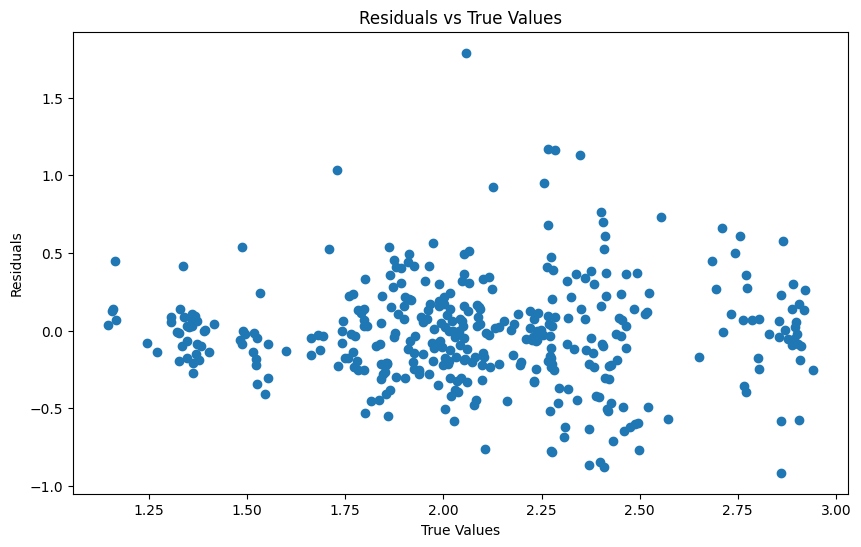

In [29]:
# Remove rows with missing band data.
cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]
X = var_cwm.drop(var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1'])
X = X[cols].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [406]:
get_sorted_feature_importances(rf.named_steps['estimator'], X.columns).head(10)

,Importance
SRAD,0.165543
SoilMoist,0.148511
ph_h20_plot,0.143222
CWD,0.143101
MSAVI2,0.037390
NDRE_Entropy,0.033672
MCARI_Corr,0.027927
MSAVI2_Entropy,0.027048
NDRE_Corr,0.026523
MSAVI2_Corr,0.026350


Soil moisture and solar irradiance of greatest importance for Nitrogen percentage when using all predictor variables. Why?

Is this information contained within the reflectance spectra? 

### Recursively remove features retaining only those most important

In [769]:
# Remove rows with missing band data.
cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]
X = var_cwm.drop(var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot'])
X = X[cols].dropna(axis=0)
y = var_cwm.loc[X.index.values, 'TraitValue']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model.
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
rf = Pipeline(
    [
    ("scaler", StandardScaler()),
    ("rfe", RFE(
        estimator=estimator, n_features_to_select=10, step=1
    ))]
)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the trait values
predictions = rf.predict(X_test)

# Calculate metrics.
r_squared = rf.score(X_test, y_test)
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100

print(f"R-squared: {r_squared:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.1f}%")

R-squared: 0.18
Root Mean Squared Error: 1.41
Mean Absolute Error: 1.01
Mean Absolute Percentage Error: 50.6%


In [771]:
selected_features = rf.named_steps['rfe'].get_feature_names_out(X.columns)
get_sorted_feature_importances(rf.named_steps['rfe'].estimator_, selected_features).head(10)

,Importance
SRAD,0.180398
B2_real,0.113339
MSAVI2_Entropy,0.103350
MSAVI2_Corr,0.098174
MCARI_Corr,0.092351
NDRE_Corr,0.084938
NDRE,0.084482
MCARI_Entropy,0.084126
B6_real,0.080535
B3_real,0.078306


### Condense bands into fewer variables
The bands are highly correlated with each other. We want to use only relevant information from the spectrum, but the raw bands have a lot of redundant information. We might try to mix the bands together somehow. 

We can use a PCA to create a few principl components along the major axes of variation that explain some $x$ amount of variance, let's say 95%. 

However, this is a linear method so assumes that the bands co-vary in a linear fashion, which is unlikely to be the case given the complicated interactions and interference phenomena between rays.

In [409]:
cols = ['S2B_PC1', 'S2B_PC2', 'S2B_PC3', *spectral_indices, *climate_vars, *soil_vars]

In [410]:
# Perform PCA on the bands to reduce multi-collinearity
# Standardize the data before PCA.
X = StandardScaler().fit_transform(var_cwm[bands].dropna(axis=0))

# Perform PCA.
pca = PCA(n_components=3)
X_pca = pca.fit_transform(var_cwm[bands].dropna(axis=0))
pca_df = pd.DataFrame(data=X_pca, columns=[f'S2B_PC{i+1}' for i in range(X_pca.shape[1])]) # Double check the indices remain what I expect.
# Concatenate the PCA components with the original data.
pca_df = pd.concat([pca_df, var_cwm.reset_index(drop=True)], axis=1)
pca.explained_variance_ratio_

array([0.80084741, 0.11973089, 0.04920048])

In [411]:
# Now check the VIF for the other variables.
X = pca_df[cols].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,S2B_PC1,3.864307
1,S2B_PC2,7.320424
2,S2B_PC3,2.120985
3,MCARI,24.212457
4,MCARI_Corr,3036.506917
5,MCARI_Entropy,127.873519
6,MSAVI2,9.926478
7,MSAVI2_Corr,557.076944
8,MSAVI2_Entropy,105.802598
9,NDRE,586.889352


R-squared: 0.67
Root Mean Squared Error: 0.30
Mean Absolute Error: 0.22
Mean Absolute Percentage Error: 11.2%


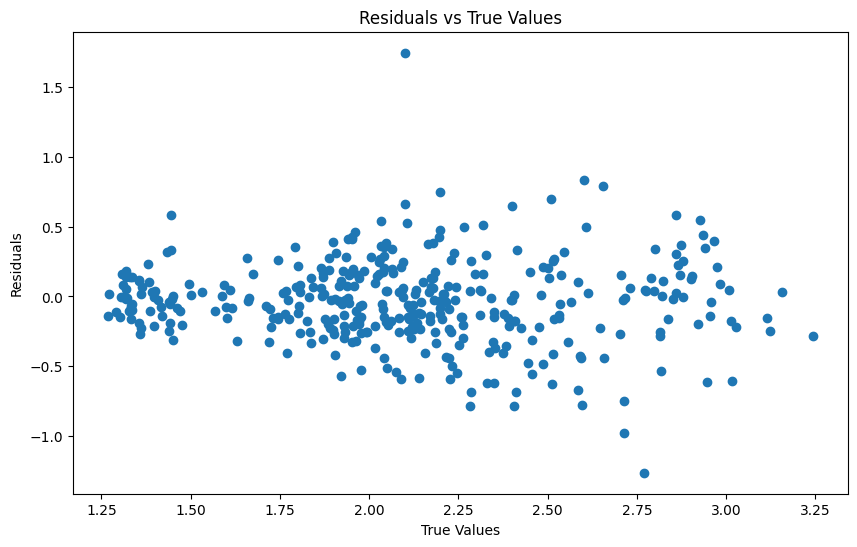

In [437]:
# Use PCA components instead of original bands.
X = pca_df.drop(pca_df.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1'])
X = X[cols].dropna(axis=0)
y = pca_df.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [415]:
get_sorted_feature_importances(rf.named_steps['estimator'], X.columns).head(15)

,Importance
SRAD,0.179110
ph_h20_plot,0.152064
SoilMoist,0.142099
CWD,0.132082
MSAVI2,0.042792
NDRE_Entropy,0.035721
MCARI_Corr,0.033772
MSAVI2_Entropy,0.032127
MCARI_Entropy,0.031466
MSAVI2_Corr,0.030433


In [289]:
# Use PCA components instead of original bands.
X = pca_df[cols].dropna(axis=0)
y = pca_df.loc[X.index.values, 'TraitValue']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model.
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
rf = Pipeline(
    [
    ("scaler", StandardScaler()),
    ("rfe", RFECV(
        estimator=estimator,
        min_features_to_select=5,
        cv=None # five-fold cross-validation
    ))]
)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the trait values
predictions = rf.predict(X_test)

# Calculate metrics.
r_squared = rf.score(X_test, y_test)
rmse = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100

print(f"R-squared: {r_squared:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.1f}%")

R-squared: 0.49
Root Mean Squared Error: 0.46
Mean Absolute Percentage Error: 10.7%


### Inspect how much variance is explained just by PCs

R-squared: 0.28
Root Mean Squared Error: 0.54
Mean Absolute Error: 0.33
Mean Absolute Percentage Error: 15.7%


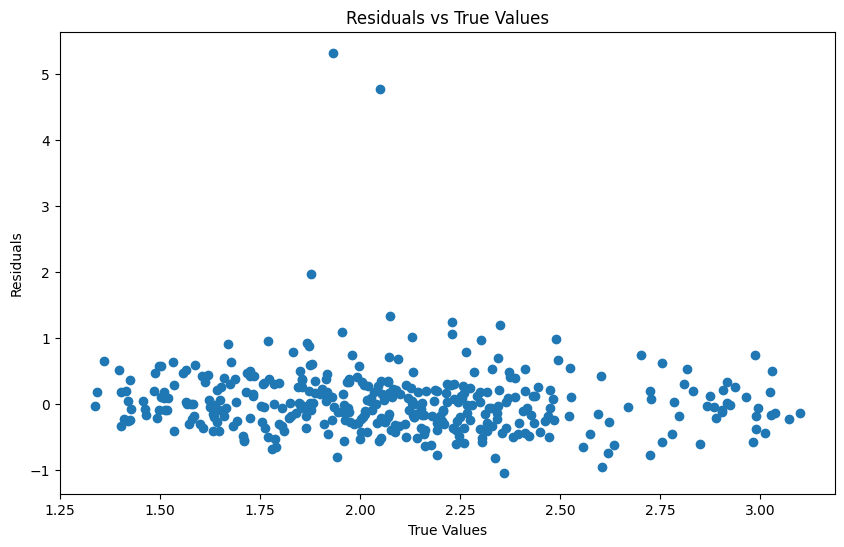

In [438]:
# Use PCA components instead of original bands.
cols = ['S2B_PC1', 'S2B_PC2', 'S2B_PC3']
X = pca_df[cols].dropna(axis=0)
y = pca_df.loc[X.index.values, 'TraitValue']

rf, _ = fit_predict_rf(X, y)

In [773]:
# Export the first three decision trees from the forest
for i in range(1):
    tree = rf.named_steps['estimator'].estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

KeyError: 'estimator'

## Apply RF model to all variables and retrieve scores

In [759]:
traits = cwms.variable.unique()
r_squared_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []

for trait in traits:
    var_cwm = cwms[cwms['variable'] == trait]
    cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['level_1']
    X = var_cwm.drop(outlier_indices)
    # Remove rows with missing band data.
    X = X[cols].dropna(axis=0)
    y = var_cwm.loc[X.index.values, 'TraitValue']

    rf, metrics = fit_predict_rf(X, y, verbose=False)
    r_squared_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    mae_scores.append(metrics[2])
    mape_scores.append(metrics[3])

# Create a DataFrame to store the results
independent_scores = pd.DataFrame({
    'Trait': traits,
    'R-squared': r_squared_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE': mape_scores
}).set_index('Trait')

In [760]:
independent_scores.sort_values(by='R-squared', ascending=False, inplace=True)
independent_scores

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Ca.Percent,0.754648,0.311143,0.176920,25.231856
Amax,0.747756,3.064644,2.282733,26.144299
Thickness.mm,0.736050,0.052369,0.036844,12.708401
N.Percent,0.676958,0.299536,0.220839,11.068149
P.Percent,0.624369,0.020926,0.014273,14.330559
K.Percent,0.554195,0.226380,0.153235,18.848750
C.Percent,0.518645,1.858118,1.257614,2.704133
Asat,0.501172,1.440645,1.055133,27.091070
Area.cm2,0.496659,67.727828,39.196584,51.847838


In [761]:
independent_scores.agg({'R-squared': 'mean', 'MAPE': 'mean'})

R-squared     0.542303
MAPE         24.510803
dtype: float64

In [762]:
traits = independent_scores.index.unique() # In order of best R^2
r_squared_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []

for i, trait in enumerate(traits):
    var_cwm = cwms[cwms['variable'] == trait].set_index('New_Plot')
    cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot']
    X = var_cwm.drop(outlier_indices)[cols]

    if i == 0:
        preds_df = pd.DataFrame(index=X.index)
        feature_importances = pd.DataFrame()
    else:
        X = X.join(preds_df, how='inner', on='New_Plot')

    y = var_cwm.loc[X.index.values, 'TraitValue']

    rf, metrics = fit_predict_rf(X, y, verbose=False)
    r_squared_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    mae_scores.append(metrics[2])
    mape_scores.append(metrics[3])

    preds = pd.DataFrame(rf.predict(X), index=X.index, columns=[f'{trait}_pred'])
    preds_df = preds_df.join(preds, how='outer', on='New_Plot')

    feature_importance = get_sorted_feature_importances(rf.named_steps['estimator'], X.columns)[:10].index.values
    feature_importances = pd.concat([feature_importances, pd.DataFrame(feature_importance, columns=[trait])], axis=1)
    
# Create a DataFrame to store the results
interdependent_scores = pd.DataFrame({
    'Trait': traits,
    'R-squared': r_squared_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE': mape_scores
}).set_index('Trait')

In [710]:
feature_importances

,Ca.Percent,Thickness.mm,Amax,N.Percent,P.Percent,K.Percent,C.Percent,Area.cm2,Asat,WD,Mg.Percent,SLA.g.m2,Dry.mass.g,Fresh.mass.g
0,ph_h20_plot,Tmax,sand_perc_plot,SoilMoist,Amax_pred,SRAD,SRAD,CWD,Amax_pred,P.Percent_pred,Ca.Percent_pred,Tmax,Area.cm2_pred,Dry.mass.g_pred
1,MSAVI2_Entropy,SoilMoist,ph_h20_plot,ph_h20_plot,N.Percent_pred,P.Percent_pred,Ca.Percent_pred,Amax_pred,MSAVI2_Corr,Area.cm2_pred,K.Percent_pred,Thickness.mm_pred,SLA.g.m2_pred,Area.cm2_pred
2,CEC_mmol_kg_plot,sand_perc_plot,Thickness.mm_pred,CWD,Ca.Percent_pred,SoilMoist,Amax_pred,N.Percent_pred,Ca.Percent_pred,CEC_mmol_kg_plot,Thickness.mm_pred,ph_h20_plot,Thickness.mm_pred,K.Percent_pred
3,NDRE_Corr,Ca.Percent_pred,MCARI_Corr,SRAD,ph_h20_plot,N.Percent_pred,Thickness.mm_pred,K.Percent_pred,C.Percent_pred,C.Percent_pred,P.Percent_pred,B4_real,Ca.Percent_pred,N.Percent_pred
4,MSAVI2_Corr,MCARI_Entropy,MSAVI2_Entropy,Thickness.mm_pred,SRAD,Ca.Percent_pred,K.Percent_pred,C.Percent_pred,K.Percent_pred,N.Percent_pred,SRAD,K.Percent_pred,MSAVI2_Entropy,Thickness.mm_pred
5,B4_real,NDRE_Corr,Ca.Percent_pred,Ca.Percent_pred,Thickness.mm_pred,MSAVI2_Entropy,N.Percent_pred,NDRE_Entropy,Area.cm2_pred,SoilMoist,SoilMoist,P.Percent_pred,CWD,Asat_pred
6,B5_real,B11_real,MSAVI2_Corr,B2_real,B2_real,ph_h20_plot,P.Percent_pred,Tmax,Tmax,Ca.Percent_pred,WD_pred,Mg.Percent_pred,WD_pred,SRAD
7,MCARI_Entropy,MSAVI2_Corr,NDRE_Corr,MSAVI2,MSAVI2_Corr,Thickness.mm_pred,Slope,Thickness.mm_pred,Thickness.mm_pred,Amax_pred,Asat_pred,N.Percent_pred,B11_real,Amax_pred
8,MCARI_Corr,MSAVI2_Entropy,CEC_mmol_kg_plot,NDRE_Entropy,MSAVI2_Entropy,Amax_pred,NDRE_Entropy,Slope,MCARI_Corr,Thickness.mm_pred,C.Percent_pred,Ca.Percent_pred,Slope,Ca.Percent_pred
9,NDRE_Entropy,MCARI_Corr,MCARI_Entropy,NDRE_Corr,NDRE_Corr,B11_real,MCARI_Corr,NDRE,NDRE_Entropy,CWD,Area.cm2_pred,Area.cm2_pred,B12_real,CWD


In [763]:
interdependent_scores.sort_values(by='R-squared', ascending=False)

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Fresh.mass.g,0.777640,0.906126,0.529186,26.846347
Ca.Percent,0.765004,0.304121,0.173648,26.566204
Asat,0.745824,1.040350,0.767856,20.293236
P.Percent,0.744224,0.017009,0.011839,12.010751
Thickness.mm,0.736623,0.053160,0.035890,12.129355
C.Percent,0.736202,1.400043,0.985583,2.095250
Amax,0.720858,3.065797,2.337103,28.247324
N.Percent,0.708290,0.269157,0.199796,9.764538
Dry.mass.g,0.692271,0.548298,0.340976,38.744989


In [764]:
interdependent_scores.agg({'R-squared': 'mean', 'MAPE': 'mean'})

R-squared     0.668851
MAPE         20.349086
dtype: float64

## Inspect improvement in predictive power when auto-regressively predicting traits.

In [766]:
# Percentage improvement
def get_percentage_improvement(independent, interdependent):
    return (interdependent - independent) / independent * 100

In [767]:
get_percentage_improvement(independent_scores, interdependent_scores)

,R-squared,RMSE,MAE,MAPE
Trait,,,,
Ca.Percent,1.372326,-2.256771,-1.849043,5.288348
Amax,-3.597173,0.037635,2.381820,8.043914
Thickness.mm,0.077806,1.510935,-2.590666,-4.556403
N.Percent,4.628378,-10.142091,-9.528693,-11.778039
P.Percent,19.196148,-18.719731,-17.052052,-16.187839
K.Percent,16.898456,-7.827177,-10.093906,-7.185272
C.Percent,41.947130,-24.652620,-21.630718,-22.516728
Asat,48.815901,-27.785798,-27.226563,-25.092526
Area.cm2,18.854203,-18.425903,-7.623515,-0.089136


In [640]:
rebuild_vars = [*climate_vars, *soil_vars, *spectral_indices]
var_reconstructions = pd.DataFrame(index=rebuild_vars, columns=['R-squared', 'VIF', 'RMSE', 'MAE', 'MAPE'])

for rebuild_var in rebuild_vars:
    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')[rebuild_var].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot']
    X = var_cwm.drop(outlier_indices)[[*bands, rebuild_var]].dropna(axis=0)
    var_reconstructions.loc[rebuild_var, 'VIF'] = variance_inflation_factor(X.values, 9)

    X = X.drop(columns=rebuild_var)
    y = var_cwm.loc[X.index.values, rebuild_var]

    _, metrics = fit_predict_rf(X, y, verbose=False)
    var_reconstructions.loc[rebuild_var, 'R-squared'] = metrics[0]
    var_reconstructions.loc[rebuild_var, 'RMSE'] = metrics[1]
    var_reconstructions.loc[rebuild_var, 'MAE'] = metrics[2]
    var_reconstructions.loc[rebuild_var, 'MAPE'] = metrics[3]

    # Plot the pairplot for the current variable
    opath = f'figures/{rebuild_var}_pairplot.png'
    if not Path(opath).exists():
        print(f'Plotting {rebuild_var}')
        sns.pairplot(X, diag_kind='kde', kind='scatter').savefig(opath)
        plt.close()

var_reconstructions.sort_values(by='R-squared', ascending=False, inplace=True)
var_reconstructions

,R-squared,VIF,RMSE,MAE,MAPE
Tmax,0.96134,50.164921,0.847903,0.376212,1.51158
MCARI,0.952001,53.256919,0.012664,0.007567,6.841991
SoilMoist,0.950185,9.578923,18.836185,7.462888,14.999559
MSAVI2_Corr,0.926068,38.849478,0.016653,0.01008,1.129582
CWD,0.892724,5.968518,7.840875,3.577473,12.103848
SRAD,0.876382,29.802903,6.819197,3.406419,1.956311
CEC_mmol_kg_plot,0.860601,9.991372,6.171871,3.287333,11.882012
MCARI_Entropy,0.860055,37.307377,0.410827,0.275358,4.053797
ph_h20_plot,0.853485,35.050497,0.141895,0.078917,1.926253
MSAVI2_Entropy,0.849605,36.221927,0.46959,0.271218,4.108464


## Test the effect of having many repeat values for an outcome variable.

In [705]:
no_unique_vals_by_var = {var: var_cwm[var].unique().size for var in rebuild_vars}
no_unique_vals_by_var

{'CWD': 22,
 'SoilMoist': 22,
 'SRAD': 22,
 'Tmax': 22,
 'Slope': 28,
 'sand_perc_plot': 27,
 'ph_h20_plot': 27,
 'CEC_mmol_kg_plot': 27,
 'MCARI': 942,
 'MCARI_Corr': 1290,
 'MCARI_Entropy': 1257,
 'MSAVI2': 1079,
 'MSAVI2_Corr': 1290,
 'MSAVI2_Entropy': 1236,
 'NDRE': 983,
 'NDRE_Corr': 1289,
 'NDRE_Entropy': 1241}

In [702]:
# no_unique_vals = list(set(no_unique_vals_by_var.values()))
no_unique_vals = np.arange(50, 1050, 50)
var_reconstructions = pd.DataFrame(index=no_unique_vals, columns=['R-squared', 'VIF'])

for no_samples in no_unique_vals:
    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')['TraitValue'].apply(get_outlier_iqr, zlim=4).reset_index()['New_Plot']
    X = var_cwm.drop(outlier_indices)

    random_vals = np.random.randn(no_samples)
    rebuild_var = np.random.choice(random_vals, X.shape[0], replace=True)
    rebuild_var = pd.Series(rebuild_var, name='Var')

    # Calculate VIF for the current variable
    X = X[bands].reset_index().drop(columns=['New_Plot']).join(rebuild_var).dropna(axis=0) # Drop NaNs from bands.
    
    var_reconstructions.loc[no_samples, 'VIF'] = variance_inflation_factor(X.values, X.shape[1]-1)

    # Fit random forest model.
    y = X['Var']
    X = X.drop(columns='Var')

    _, metrics = fit_predict_rf(X, y, verbose=False)
    var_reconstructions.loc[no_samples, 'R-squared'] = metrics[0]

var_reconstructions.sort_values(by='R-squared', ascending=False, inplace=True)
var_reconstructions

,R-squared,VIF
400,-0.07946,1.012629
1000,-0.094679,1.006715
650,-0.101057,1.017491
150,-0.104928,1.020063
900,-0.117096,1.013268
700,-0.120613,1.00894
100,-0.127855,1.001801
950,-0.137974,1.008244
850,-0.13819,1.007014
600,-0.142072,1.006319


Text(0.5, 0, 'Number of unique values')

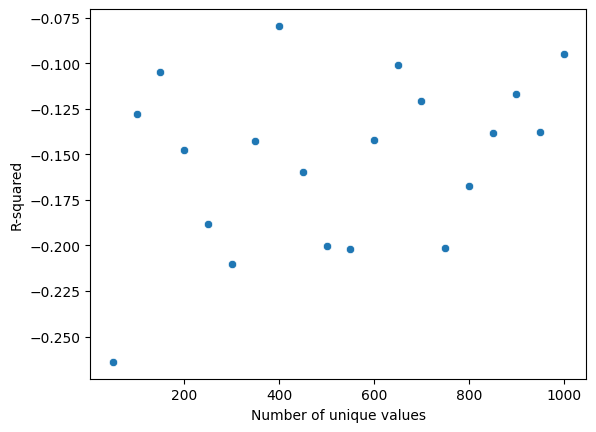

In [704]:
sns.scatterplot(data=var_reconstructions, x=var_reconstructions.index, y='R-squared')
plt.xlabel('Number of unique values')

In [ ]:

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}